## Pose_Estimation

### Strategy-1: Using Coordinates as input and Lables (Correct & Incorrect) using PCA and feature selection

#### Install requierd libraries

In [ ]:
'''Install requiered dependencies/libraries
-pip install numpy
-pip install opencv-python
-pip install scikit-learn
-pip install tensorflow
-pip install keras
-pip install hmmlearn
-pip install matplotlib
-pip install mediapipe ... for coordinate extracting
'''

#### Import installed and required python libraries

In [1]:
#Import requiered  installed libraries
import os
import csv
import cv2
import json
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest, f_classif
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

### 1) Load & Process the dataset

In [2]:
# Function to apply PCA to the data
def apply_pca(data, n_components):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

In the above code, the apply_pca() function is a utility function that applies Principal Component Analysis (PCA) to a given dataset. PCA is a dimensionality reduction technique that identifies the most important patterns in the data by finding a new set of orthogonal axes called principal components.

The function takes two parameters: data, which represents the input dataset, and n_components, which specifies the desired number of components to keep. Within the function, a PCA object is created with the specified number of components.

The fit_transform() method of the PCA object is then called on the input data, which performs the actual PCA transformation. This step computes the principal components and transforms the original data into a new lower-dimensional space. The result, data_pca, is the transformed dataset.

Finally, the function returns both the transformed dataset, data_pca, and the PCA object itself, pca. This allows for further analysis or using the trained PCA model on new data. By applying PCA, the function helps in reducing the dimensionality of the data and extracting the most significant information for subsequent processing or modeling tasks.

In [3]:
# Function to apply feature selection using ANOVA F-value
def apply_feature_selection(data, labels, k):
    feature_selector = SelectKBest(f_classif, k=k)
    data_selected = feature_selector.fit_transform(data, labels)
    return data_selected, feature_selector

The above code utilize function `apply_feature_selection()` that applies feature selection using the ANOVA F-value method. Feature selection is a process of selecting a subset of relevant features from the original dataset, which can help improve model performance, reduce overfitting, and enhance interpretability.

The function takes three parameters: `data`, which represents the input dataset, `labels`, which are the corresponding labels or target values for the data, and `k`, which specifies the number of top features to select.

Within the function, a `SelectKBest` object is created with the ANOVA F-value scoring function. The ANOVA F-value measures the relationship between each feature and the target variable. It evaluates the variance between different classes or groups and the variance within each class. 

The `fit_transform()` method of the feature selector object is then called on the input data and labels. This step performs the actual feature selection by computing the ANOVA F-value scores for each feature and selecting the top `k` features with the highest scores. The result, `data_selected`, is the transformed dataset containing only the selected features.

Finally, the function returns both the transformed dataset, `data_selected`, and the feature selector object itself, `feature_selector`. This allows for further analysis or using the trained feature selector on new data.

By applying feature selection using the ANOVA F-value method, the function helps in reducing the dimensionality of the data by selecting the most informative features that are likely to be most relevant for predicting the target variable.

In [4]:
# Constants
exercise = "squat"
keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In the  above code, there are two constants defined: exercise and keypoint_indices.

1) exercise = "squat": This constant variable is assigned the value "squat", indicating that the code is likely related to the exercise movement or pose detection for the squat exercise. The variable exercise can be used later in the code to specify or categorize the exercise type.

2) keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]: This constant variable is assigned a list of integers representing keypoint indices. Keypoints are specific points on a human body detected by a pose estimation algorithm. Each index in the keypoint_indices list corresponds to a specific keypoint on the body. The list contains 25 (joints) indices from 0 to 24,representing different parts of the body or joints. These indices can be used later in the code to access or manipulate specific keypoints or body parts during pose analysis below.

In [19]:
# Process the JSON files and extract pose data
def process_json_files(data_dir):
    data = []
    labels = []
    folder_names = []

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Add the folder name to the list
        folder_names.append(folder_name)

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                for frame_data in json_data["joints3d_25"]:
                    pose_data = []

                    # Extract coordinates for each body part
                    for part_coords in frame_data:
                        pose_data.extend(part_coords)

                    # Append the pose data and label to the lists
                    data.append(pose_data)
                    labels.append(label)

    return data, labels, folder_names

The `process_json_files` function takes a directory path as input, processes the JSON files within that directory, and extracts pose data from them. It returns three lists: `data`, `labels`, and `folder_names`.

The function starts by initializing empty lists for `data`, `labels`, and `folder_names`. It then iterates over the folders in the given directory using `os.listdir`. For each folder, it checks if it's a directory and skips any non-directory files.

Next, it determines the label based on whether the folder name is "s08". If it is, the label is set as "correct"; otherwise, it is set as "incorrect". The folder name is also added to the `folder_names` list.

The function constructs the path to the "joints3d_25" folder within each directory and iterates over the files within that folder. It checks if the file is a JSON file and not a ".DS_Store" file. If it meets the criteria, it opens and parses the JSON file using `json.load`.

Within each JSON file, it extracts skeleton coordinates for each frame. It iterates over the "joints3d_25" data and extracts the coordinates for each body part. The coordinates are then appended to the `pose_data` list.

Finally, the `pose_data` and label are appended to the `data` and `labels` lists, respectively. After processing all the files, the function returns the `data`, `labels`, and `folder_names` lists.

In summary, the `process_json_files` function reads JSON files in a given directory, extracts pose data from them, assigns labels based on folder names, and returns the collected pose data, corresponding labels, and folder names.

In [8]:
# Specify the data directory
data_dir = "D:/AI/pos_estimation/train/train"

In [9]:
# Process the JSON files
data, labels, folder_names = process_json_files(data_dir)

In [8]:
# Print the folder names
for folder_name in folder_names:
    print("Folder:", folder_name)

Folder: s03
Folder: s04
Folder: s05
Folder: s07
Folder: s08
Folder: s09
Folder: s10
Folder: s11


### Calculate the angles (You can SKIP this one if it run once)

### Corrected!

In [36]:
# Function to calculate the angle between three points given their coordinates
def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    ba = a - b
    bc = c - b

    dot_product = np.dot(ba, bc)
    norm_product = np.linalg.norm(ba) * np.linalg.norm(bc)

    cos_theta = dot_product / norm_product
    angle_rad = np.arccos(cos_theta)
    angle = np.degrees(angle_rad)

    return angle
# Process the JSON files and extract pose data
def process_json_files(data_dir):
    data = {}

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                frame_angles = []

                for frame_data in json_data["joints3d_25"]:
                    pose_data = []

                    # Extract coordinates for each body part
                    for idx in keypoint_indices:
                        coord = frame_data[idx]
                        pose_data.append(coord)

                    # Calculate angles
                    angles = [
                        calculate_angle(pose_data[18], pose_data[3], pose_data[2]),  # Angle 1 (left ankle)
                        calculate_angle(pose_data[20], pose_data[6], pose_data[5]),  # Angle 2 (right ankle)
                        calculate_angle(pose_data[3], pose_data[2], pose_data[1]),  # Angle 3 (left knee)
                        calculate_angle(pose_data[6], pose_data[5], pose_data[4]),  # Angle 4 (right knee)
                        calculate_angle(pose_data[1], pose_data[0], pose_data[4]),  # Angle 5 (hip angle)
                        calculate_angle(pose_data[0], pose_data[7], pose_data[8]),  # Angle 6 (spine angle)
                        calculate_angle(pose_data[7], pose_data[8], pose_data[11]),  # Angle 7 (left-side shoulder angle)
                        calculate_angle(pose_data[7], pose_data[8], pose_data[14]),  # Angle 8 (right-side shoulder angle)
                        calculate_angle(pose_data[8], pose_data[11], pose_data[12]),  # Angle 9 (left shoulder angle)
                        calculate_angle(pose_data[8], pose_data[14], pose_data[15]),  # Angle 10 (right shoulder angle)
                        calculate_angle(pose_data[11], pose_data[12], pose_data[13]),  # Angle 11 (left elbow angle)
                        calculate_angle(pose_data[14], pose_data[15], pose_data[16]),  # Angle 12 (right elbow angle)
                        calculate_angle(pose_data[8], pose_data[9], pose_data[10]),  # Angle 13 (head angle)
                        calculate_angle(pose_data[1], pose_data[0], pose_data[7]),  # Angle 14 (left hip angle)
                        calculate_angle(pose_data[4], pose_data[0], pose_data[7]),  # Angle 15 (right hip angle)
                        # Not so much important but added
                        calculate_angle(pose_data[21], pose_data[13], pose_data[22]),  # Angle 16 (left wrist angle)
                        calculate_angle(pose_data[23], pose_data[16], pose_data[24])  # Angle 17 (right wrist angle)
                        
                    ]

                    frame_angles.append(angles)

                # Append the angles to the corresponding label
                if label not in data:
                    data[label] = []
                data[label].append((file_path, frame_angles))  # Save file path along with angles

    return data

# Save all frames' angles to a CSV file with the same name as the JSON file in the same directory
def save_angles_to_csv(angles):
    for label, angle_list in angles.items():
        for file_path, frame_angles in angle_list:
            json_dir = os.path.dirname(file_path)
            json_name = os.path.basename(file_path)
            csv_file = os.path.join(json_dir, f"{os.path.splitext(json_name)[0]}.csv")
            with open(csv_file, "w", newline="") as file:
                writer = csv.writer(file)
                headers = ["Frame", "Label"] + [f"Angle {i+1}" for i in range(len(frame_angles[0]))]
                writer.writerow(headers)

                if label == "correct":
                    label_value = "correct"
                else:
                    label_value = "incorrect"

                frame_idx = 1
                for angles in frame_angles:
                    row = [frame_idx, label_value] + angles
                    writer.writerow(row)
                    frame_idx += 1

# Specify the data directory
data_dir = "D:/AI/pos_estimation/train/train"

# Process the JSON files and extract pose data
angles = process_json_files(data_dir)

# Save all frames' angles to CSV files
save_angles_to_csv(angles)

print("Angles saved to CSV files.")

Angles saved to CSV files.


### Feature slection for angles

In [31]:
# Load angles data from a CSV file
def load_angles_data(csv_file):
    with open(csv_file, "r") as file:
        reader = csv.reader(file)
        data = list(reader)
    
    # Remove the header row
    data = data[1:]
    
    # Convert the angle data to a numpy array
    angles_data = np.array(data, dtype=float)
    
    return angles_data

In [32]:
# Load the angles data from the CSV files
pose_data = []
for label, angle_list in angles.items():
    for _, frame_angles in angle_list:
        pose_data.extend(frame_angles)
pose_data = np.array(pose_data)

In [25]:
# Access the angles for the original data (not reduced)
angles_data = pose_data[:, -len(keypoint_indices):]

### Prepare the dataset for PCA

In [26]:
print("Pose Data:")
print(pose_data)

Pose Data:
[[170.11761338 115.63304224  59.7746437  ... 171.27541731   7.14338664
  167.49339856]
 [170.11761338 115.63304224  59.7746437  ... 171.27541731   7.14338664
  167.49339856]
 [169.82409228 115.95230703  59.73678823 ... 171.29554276   7.0926096
  167.48648243]
 ...
 [ 89.51019577 178.85303264  59.88379689 ... 118.15160378  51.67776894
   96.65872312]
 [ 89.57779448 178.80270988  59.72601426 ... 117.77859568  51.94897427
   96.79095906]
 [ 89.64465641 178.76972568  59.6063789  ... 117.41214521  52.2027358
   97.60050863]]


In [27]:
# Apply PCA to the pose data
n_pca_components = 3  # Number of PCA components to keep
pose_data_pca, pca = apply_pca(pose_data, n_pca_components)

PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional representation while preserving the most important information.
The line of above code pose_data_pca, pca = apply_pca(pose_data, n_pca_components) applies PCA to the pose_data using n_pca_components as the number of components to keep. The function apply_pca() takes the pose_data as input and returns two values: pose_data_pca, which contains the transformed data after PCA, and pca, which represents the PCA model used for the transformation.

By applying PCA, I have reduced the dimensionality of the pose data to n_pca_components (in this case, 3), which means that each data point in pose_data is now represented by a lower-dimensional vector in pose_data_pca. This can help in reducing the complexity of the data and potentially capturing the most relevant information for further analysis or modeling.

In [28]:
# Apply feature selection using ANOVA F-value
k_features = 3  # Select all features after PCA
pose_data_selected, feature_selector = apply_feature_selection(pose_data_pca, pose_labels, k_features)

For the above code, k_features is set to 3, indicating that you want to select 3 features after applying PCA. The variable pose_data_pca represents the data after applying Principal Component Analysis (PCA) using the apply_pca() function. pose_labels contains the corresponding labels for the data.

The apply_feature_selection() function takes three arguments: the data (pose_data_pca), the labels (pose_labels), and the number of features to select (k_features). It performs feature selection using the ANOVA F-value method and returns the selected data (pose_data_selected) and the feature selector object (feature_selector).

By calling apply_feature_selection(pose_data_pca, pose_labels, k_features), you are applying the ANOVA F-value feature selection on the PCA-transformed data (pose_data_pca) with the specified number of features (k_features). The resulting selected data with the desired number of features is stored in pose_data_selected.

In [30]:
# Print the shape of the processed data
print("Shape of processed data:", pose_data_selected.shape)

Shape of processed data: (20901, 3)


The output provided above indicates that the processed data, pose_data_selected, has a shape of (20901, 3). This means that pose_data_selected is a 2-dimensional NumPy array with 20901 rows and 3 columns.

The shape (20901, 3) suggests that each data sample in pose_data_selected has been reduced to 3 features after applying feature selection. The reduction in the number of features can be attributed to the feature selection technique used; ANOVA F-value, which selects the k-best features based on their relevance to the target labels.

The shape depends on the preprocessing steps and feature selection criteria applied to the original data.

In [17]:
# Access the PCA components and selected feature indices
pca_components = pca.components_
selected_feature_indices = feature_selector.get_support(indices=True)

NameError: name 'pca' is not defined

In [16]:
# Access the angles for the original data (not reduced)
#angles_data = pose_data[:, -len(keypoint_indices):]  # Assuming angles are at the end of the data

In [17]:
# Print the shape of the angles data
print("Shape of angles data:", angles_data.shape)

Shape of angles data: (20901, 25)


### Additional process

In [29]:
# Constants
num_classes = 2  # Number of classes (Correct or Incorrect)
input_shape = (pose_data_selected.shape[1],)  # Input shape for the CNN model

In [30]:
# Split the reduced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pose_data_selected, pose_labels, test_size=0.2, random_state=42)

In [31]:
# Convert the labels to integer values using label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [32]:
# Convert the encoded labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

### 2) Feature Extraction with CNN

1) Model

In [33]:
# Build the CNN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape))
model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) # Number of classes (Correct or Incorrect)

In [34]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 1)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             128       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [35]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
# Train the model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
262/262 [==============================] - 7s 6ms/step - loss: 0.2789 - accuracy: 0.9145 - val_loss: 0.1926 - val_accuracy: 0.9503
Epoch 2/10
262/262 [==============================] - 1s 5ms/step - loss: 0.1488 - accuracy: 0.9553 - val_loss: 0.1407 - val_accuracy: 0.9531
Epoch 3/10
262/262 [==============================] - 1s 4ms/step - loss: 0.1063 - accuracy: 0.9630 - val_loss: 0.1039 - val_accuracy: 0.9624
Epoch 4/10
262/262 [==============================] - 1s 5ms/step - loss: 0.0846 - accuracy: 0.9707 - val_loss: 0.0802 - val_accuracy: 0.9699
Epoch 5/10
262/262 [==============================] - 1s 4ms/step - loss: 0.0704 - accuracy: 0.9742 - val_loss: 0.0682 - val_accuracy: 0.9706
Epoch 6/10
262/262 [==============================] - 2s 6ms/step - loss: 0.0608 - accuracy: 0.9761 - val_loss: 0.0658 - val_accuracy: 0.9732
Epoch 7/10
262/262 [==============================] - 1s 3ms/step - loss: 0.0549 - accuracy: 0.9797 - val_loss: 0.0545 - val_accuracy: 0.9792
Epoch 

#### Validation parameters

In [37]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

131/131 [==============================] - 0s 3ms/step - loss: 0.0469 - accuracy: 0.9825
Test loss: 0.04692898690700531
Test accuracy: 0.9825400710105896


In [39]:
# Calculate the average accuracy and error
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Print the average accuracy and error
print("Average Accuracy:")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")

print("Average Loss:")
print(f"  Training Loss: {train_loss:.4f}")
print(f"  Validation Loss: {val_loss:.4f}")

Average Accuracy:
  Training Accuracy: 0.9850
  Validation Accuracy: 0.9825
Average Loss:
  Training Loss: 0.0417
  Validation Loss: 0.0469


#### Plot the training results

In [40]:
# Get the training and validation metrics from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

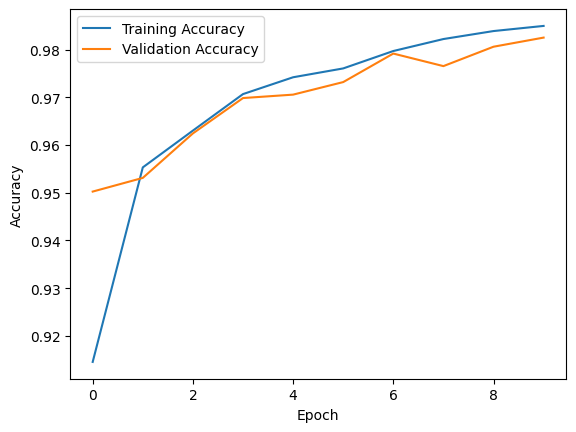

In [42]:
# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

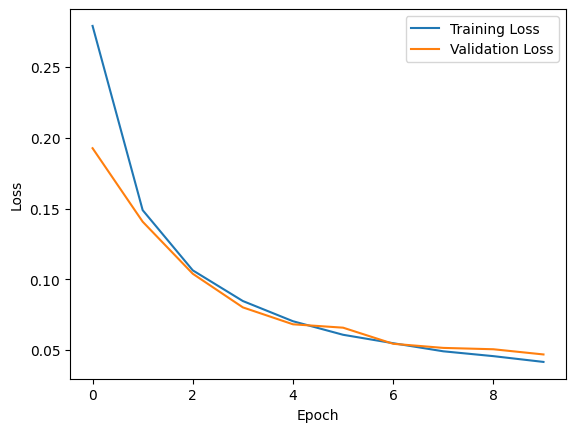

In [43]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Save the best model

In [44]:
# Specify the path to save the model
path_to_save_model = "D:/AI/pos_estimation/best_models/three"

# Save the model
model.save(path_to_save_model)

INFO:tensorflow:Assets written to: D:/AI/pos_estimation/best_models/three\assets


INFO:tensorflow:Assets written to: D:/AI/pos_estimation/best_models/three\assets


In [45]:
# Save the model to the specified file
model.save('D:/AI/pos_estimation/best_models/three/best_model.h5')

#### Test the above model

#### Coordinate extracting

In [46]:
# Coordiante extracting from landmarks using mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

#### For whole three video coordinate extraction

In [ ]:
# Function to calculate angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Mid point
    c = np.array(c)  # End point
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    {'directory': 's13', 'filename': 'squat.mp4'},
    {'directory': 's02', 'filename': 'squat.mp4'},
    {'directory': 's12', 'filename': 'squat.mp4'}
]

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        frame_counter = 0  # Initialize frame counter
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append([x, y, z])
                coordinates.append(frame_coordinates)
                
                # Calculate angle using the three coordinate points
                angle_index = 1  # Initialize angle index
                for i in range(len(frame_coordinates) - 2):
                    a, b, c = frame_coordinates[i:i+3]
                    angle = calculate_angle(a, b, c)
                    print(f"Angle-{angle_index}: {angle}")
                    angle_index += 1
            except:
                pass

            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                                     mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

            frame_counter += 1  # Increment frame counter

        cap.release()
        cv2.destroyAllWindows()

    print("Number of frames processed:", frame_counter)

    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'

# Process each test video
for video in test_videos:
    video_directory = video['directory']
    video_filename = video['filename']
    video_path = os.path.join(test_folder, video_directory, 'videos', video_filename)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}: {}".format(video_directory, coordinates))

    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, 'squat', video_directory)
    os.makedirs(video_dir, exist_ok=True)

    # Create the coordinates dictionary with the specified format
    coordinates_dict = {"test_coordinates": coordinates}

    # Save the coordinates as a JSON file
    output_file = os.path.join(video_dir, 'squat_coordinates.json')
    with open(output_file, 'w') as f:
        json.dump(coordinates_dict, f)

    print("Saved coordinates for video {} to {}".format(video_directory, output_file))


#### Calculate the angles and save it as CSV file

In [163]:
# Define the indices of the body parts you want to detect
body_part_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Function to calculate the angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Mid point
    c = np.array(c)  # End point

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    coordinates = []
    cap = cv2.VideoCapture(video_path)
    with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                frame_coordinates = []
                for idx, landmark in enumerate(landmarks):
                    if idx in body_part_indices:
                        x, y, z = landmark.x, landmark.y, landmark.z
                        frame_coordinates.append((x, y, z))
                coordinates.append(frame_coordinates)
            except:
                pass

            # Render detections
            mp.solutions.drawing_utils.draw_landmarks(
                image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    return coordinates

# Create the main directory for saving the coordinates
output_dir = r'D:\AI\pos_estimation\test_coordinates'

# Process each test video
for video in test_videos:
    video_directory = video['directory']
    video_filename = video['filename']
    video_path = os.path.join(test_folder, video_directory, 'videos', video_filename)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates for video {}: {}".format(video_directory, coordinates))

    # Create the output directory for the video if it doesn't exist
    video_dir = os.path.join(output_dir, 'squat', video_directory)
    os.makedirs(video_dir, exist_ok=True)

    # Save the coordinates as a JSON file
    output_file = os.path.join(video_dir, 'squat_coordinates.json')
    with open(output_file, 'w') as f:
        json.dump(coordinates, f)

    print("Saved coordinates for video {} to {}".format(video_directory, output_file))

    # Calculate angles
    angles = []
    for frame_coordinates in coordinates:
        if len(frame_coordinates) >= 3:
            a, b, c = frame_coordinates[-3:]
            angle = calculate_angle(a, b, c)
            angles.append(angle)

    # Save the angles as a CSV file in the same directory
    angles_file = os.path.join(video_dir, 'angles.csv')
    with open(angles_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Frame', 'Angle'])
        for i, angle in enumerate(angles):
            writer.writerow([i+1, angle])

    print("Saved angles for video {} to {}".format(video_directory, angles_file))


Coordinates for video s13: [[(0.4585586488246918, 0.2242552936077118, -0.38884687423706055), (0.46105101704597473, 0.215047687292099, -0.36830276250839233), (0.46322670578956604, 0.21491877734661102, -0.368322491645813), (0.46555477380752563, 0.21486316621303558, -0.3683587610721588), (0.4521242380142212, 0.2153727412223816, -0.3790733516216278), (0.44792675971984863, 0.21562306582927704, -0.37914958596229553), (0.4438645839691162, 0.2160245031118393, -0.3791848421096802), (0.4658338129520416, 0.2186002880334854, -0.23109309375286102), (0.4346451759338379, 0.22081610560417175, -0.28173503279685974), (0.46212226152420044, 0.234828382730484, -0.3355633318424225), (0.4509980380535126, 0.23511233925819397, -0.35025298595428467), (0.48852187395095825, 0.2866054177284241, -0.10569220036268234), (0.4000275135040283, 0.2880116403102875, -0.20316071808338165), (0.5031436085700989, 0.3603900969028473, -0.02931823395192623), (0.37742534279823303, 0.36617717146873474, -0.16518713533878326), (0.526

### Apply PCA and feature extraction fo test JASON file

In [164]:
# Function to apply PCA to the test data
def apply_pca_test(test_data, n_components_test):
    pca_test = PCA(n_components=n_components_test)
    data_pca_test = pca.fit_transform(test_data)
    return data_pca_test, pca_test

In [165]:
# Function to apply feature selection using ANOVA F-value
def apply_feature_selection_test(test_data, k):
    feature_selector_test = SelectKBest(f_classif, k=k)
    data_selected_test = feature_selector_test.fit_transform(test_data)
    return data_selected_test, feature_selector_test

In [166]:
def process_json_files_test(test_data_dir):
    test_data = []
    test_folder_names = []

    # Iterate over the folders in the data directory
    for test_folder_name in os.listdir(test_data_dir):
        test_folder_path = os.path.join(test_data_dir, test_folder_name)

        # Skip non-directory files
        if not os.path.isdir(test_folder_path):
            continue

        # Add the folder name to the list
        test_folder_names.append(test_folder_name)

        # Get the path to the squat_coordinates.json file
        json_file_path = os.path.join(test_folder_path, "squat_coordinates.json")

        # Process the squat_coordinates.json file
        if os.path.isfile(json_file_path):
            print("Processing:", json_file_path)

            # Open and parse the JSON file
            with open(json_file_path, "r") as f:
                json_data = json.load(f)

            # Extract skeleton coordinates for the frame
            frame_data = json_data[0]
            pose_data_test = []

            # Extract coordinates for each body part
            for part_coords in frame_data:
                pose_data_test.extend(part_coords)

            # Append the pose data to the test_data list
            test_data.append(pose_data_test)

    return test_data, test_folder_names

In [167]:
# Specify the data directory
test_data_dir = "D:/AI/pos_estimation/test_coordinates/squat"

In [168]:
# Process the JSON files
test_data, test_folder_names = process_json_files_test(test_data_dir)

Processing: D:/AI/pos_estimation/test_coordinates/squat\s02\squat_coordinates.json
Processing: D:/AI/pos_estimation/test_coordinates/squat\s12\squat_coordinates.json
Processing: D:/AI/pos_estimation/test_coordinates/squat\s13\squat_coordinates.json


In [169]:
# Print the test_data
print(test_data)

[[0.6010845303535461, 0.308633029460907, 0.0718226209282875, 0.5972101092338562, 0.2995258569717407, 0.06137905642390251, 0.594839334487915, 0.2986583113670349, 0.061402738094329834, 0.5924144983291626, 0.2976681590080261, 0.061438143253326416, 0.6020565032958984, 0.3006012439727783, 0.043764762580394745, 0.6031332612037659, 0.3005468547344208, 0.04378412291407585, 0.6042370796203613, 0.30035489797592163, 0.04371952638030052, 0.581125020980835, 0.29905813932418823, 0.025997918099164963, 0.5977795124053955, 0.30218642950057983, -0.053068578243255615, 0.5931188464164734, 0.3146445155143738, 0.06493843346834183, 0.5984936952590942, 0.3160441219806671, 0.04185434430837631, 0.5321024656295776, 0.3531832993030548, 0.04906591773033142, 0.6097326874732971, 0.3554533123970032, -0.12766793370246887, 0.5223703980445862, 0.4257810115814209, 0.06889356672763824, 0.6189597845077515, 0.42807912826538086, -0.11214473843574524, 0.5206316709518433, 0.4932810068130493, 0.08179982006549835, 0.640588879585

In [170]:
# Print the folder names
for folder_name in test_folder_names:
    print("Folder:", folder_name)

Folder: s02
Folder: s12
Folder: s13


In [171]:
# Convert the data to numpy arrays
pose_data_test = np.array(test_data)

In [172]:
# Apply PCA to the pose_data_test
n_pca_components_test = 3  # Number of PCA components to keep
pose_data_pca_test, pca_test = apply_pca_test(pose_data_test, n_pca_components_test)

In [173]:
# Print the shape of the processed data
print("Shape of processed data:", pose_data_pca_test.shape)

Shape of processed data: (3, 3)


In [159]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Set the number of components you want to keep
test_data_pca = pca.fit_transform(test_data)

# Apply feature selection using SelectKBest and f_regression
feature_selector = SelectKBest(score_func=f_regression, k=5)  # Set the number of features you want to select
test_data_selected = feature_selector.fit_transform(test_data_pca, labels)

# Print the shape of the transformed and selected dataset
print("Shape of transformed and selected dataset:", test_data_selected.shape)


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Test the model

##### Notice that:
- 0 : INCORRECT
- 1 : CORRECT

In [93]:
# Test-1:

model = keras.models.load_model(r'D:\AI\pos_estimation\best_models\one\best_model.h5')
with open(r'D:\AI\pos_estimation\test_coordinates\squat\s13\squat_coordinates.json') as file:
    data = json.load(file)

# Extract the coordinates from the loaded JSON data
coordinates = np.array(data)  # No need for data['coordinates']
predictions = model.predict(coordinates)
predicted_labels = np.argmax(predictions, axis=1)

label_mapping = {0: 'correct', 1: 'incorrect'}
interpreted_labels = [label_mapping[label] for label in predicted_labels]
# Print the interpreted labels
print(interpreted_labels)


46/46 [==============================] - 0s 3ms/step
['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 

                                        **********************************